## Introduction

In this project, we’ll play the role of a data scientist working for a credit card company. We’ve been given a dataset containing information about the company’s clients and asked to help segment them into different groups in order to apply different business strategies for each type of customer.

The company expects to receive a group for each client and also an explanation of the characteristics of each group and what are the main points that make them different.

In a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

In order to use the algorithm properly and achieve all the goals that the company has set for us, we'll go through the following steps:

Analyse the dataset;
- Prepare the data for modeling;
- Find an appropriate number of clusters;
- Segment the data;
- Interpret and explain the results.

Here's the data dictionary:
- customer_id: unique identifier for each customer.
- age: customer age in years.
- gender: customer gender (M or F).
- dependent_count: number of dependents of each customer.
- education_level: level of education ("High School", "Graduate", etc.).
- marital_status: marital status ("Single", "Married", etc.).
- estimated_income: the estimated income for the customer projected by the data science team.
- months_on_book: time as a customer in months.
- total_relationship_count: number of times the customer contacted the company.
- months_inactive_12_mon: number of months the customer did not use the credit card in the last 12 months.
- credit_limit: customer's credit limit.
- total_trans_amount: the overall amount of money spent on the card by the customer.
- total_trans_count: the overall number of times the customer used the card.
- avg_utilization_ratio: daily average utilization ratio. 0

We'll start by importing the packages we'll use.

In [1]:
#doing the imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv('customer_segmentation.csv')
df.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


## Exploratory Data Analysis
After reading the data into pandas, it's time to explore it. Let's investigate the size of the dataset, what columns it contains, the type of values in each column, and also check on missing values.

In [3]:
df.shape

(10127, 14)

There is 10127 rows with 14 columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

Based on this we can see that there are 11 numeric columns with 3 categorical columns

In [5]:
df.isnull().sum()

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64

No missing values which is good

In [6]:
cols=['gender','education_level','marital_status']

for i in cols:
    print(df[i].value_counts())

F    5358
M    4769
Name: gender, dtype: int64
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64


Here we can see how many unique categories are there in each categorical variable and how many datapoints per category.

As we're working with unsupervised machine learning, there isn't a target variable on which we can measure the impacts of the other variables.

But we can see the correlation between the numeric variables and their distributions.

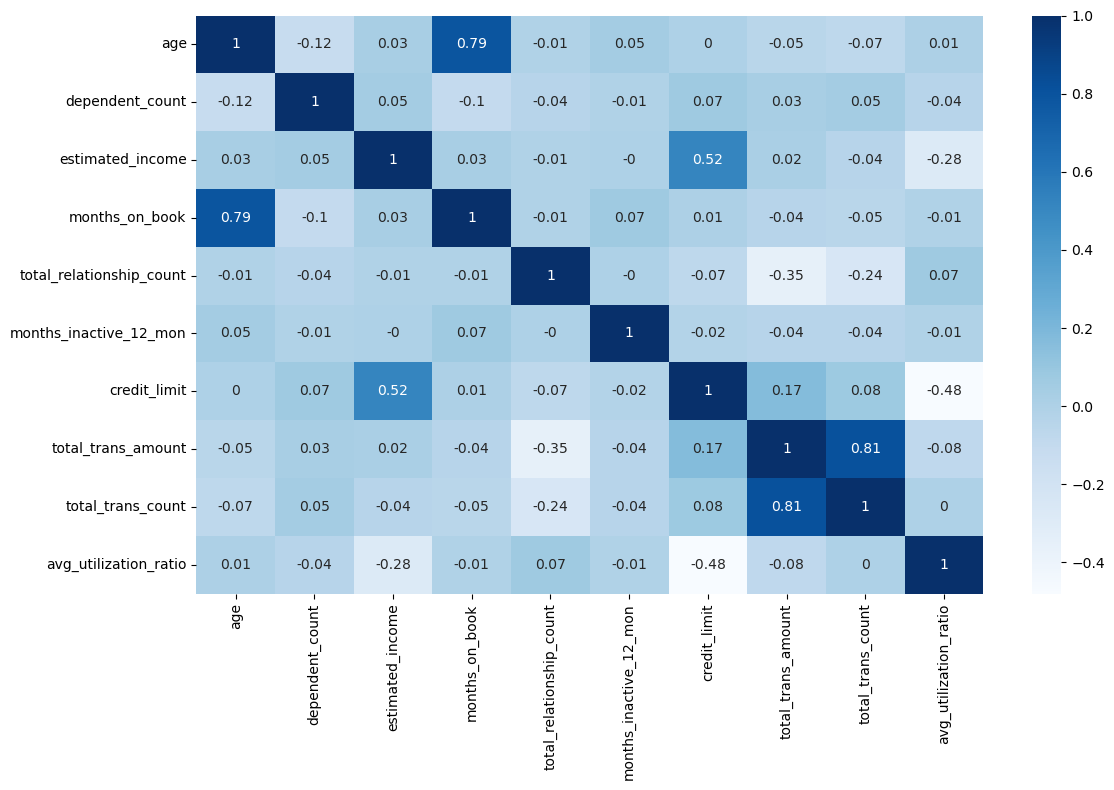

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(round(df.drop('customer_id', axis=1).corr(), 2), cmap='Blues', annot=True, ax=ax)
plt.tight_layout()

Most of the variables present weak correlations between each other, but there are some we can highlight:

- Age is strongly correlated with how long the person has been a customer (months_on_book);
- Credit limit is positively correlated with the estimated income and negatively correlated with the average utilization ratio;
- The total number of transactions (total_trans_count) is strongly correlated with the total amount transitioned (total_trans_amount).

In [8]:
df.corr()

,customer_id,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
customer_id,1.000000,0.007613,0.006772,0.015787,0.134588,0.006907,0.005729,0.005708,-0.019692,-0.002961,0.000266
age,0.007613,1.000000,-0.122254,0.032922,0.788912,-0.010931,0.054361,0.002476,-0.046446,-0.067097,0.007114
dependent_count,0.006772,-0.122254,1.000000,0.051620,-0.103062,-0.039076,-0.010768,0.068065,0.025046,0.049912,-0.037135
estimated_income,0.015787,0.032922,0.051620,1.000000,0.027628,-0.007181,-0.002703,0.515863,0.015861,-0.039988,-0.277532
months_on_book,0.134588,0.788912,-0.103062,0.027628,1.000000,-0.009203,0.074164,0.007507,-0.038591,-0.049819,-0.007541
total_relationship_count,0.006907,-0.010931,-0.039076,-0.007181,-0.009203,1.000000,-0.003675,-0.071386,-0.347229,-0.241891,0.067663
months_inactive_12_mon,0.005729,0.054361,-0.010768,-0.002703,0.074164,-0.003675,1.000000,-0.020394,-0.036982,-0.042787,-0.007503
credit_limit,0.005708,0.002476,0.068065,0.515863,0.007507,-0.071386,-0.020394,1.000000,0.171730,0.075927,-0.482965
total_trans_amount,-0.019692,-0.046446,0.025046,0.015861,-0.038591,-0.347229,-0.036982,0.171730,1.000000,0.807192,-0.083034
total_trans_count,-0.002961,-0.067097,0.049912,-0.039988,-0.049819,-0.241891,-0.042787,0.075927,0.807192,1.000000,0.002838


/tmp/ipykernel_5693/2008510823.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.drop('customer_id',axis=1).hist(ax=ax)


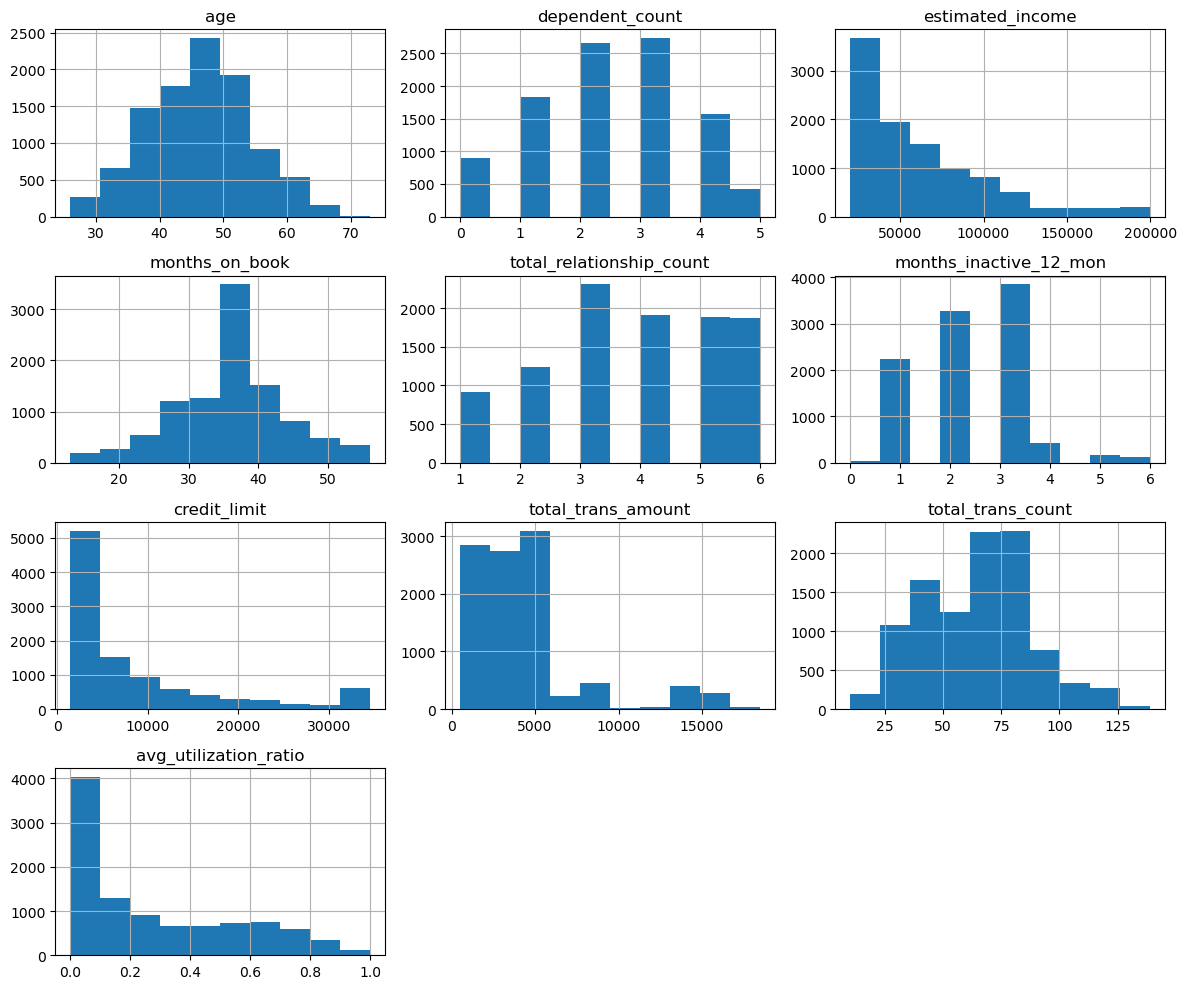

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
#removing the customer id from the dataframe before we plot it

df.drop('customer_id',axis=1).hist(ax=ax)
plt.tight_layout()

## Feature Engineering

Let's start dealing with the categorical columns. There are three of them: gender, education level, and marital status.

First, let's check on the gender and education_level columns.

The gender column contains only 2 unique values, "M" and "F", which means it's possible to replace all the rows with 1 and 0.

The education_level column contains 6 uniques values. This column represents levels of education, and it's possible to rank the levels from the lowest to the highest, so it's possible to replace each unique level with a number, assuming we respect the order.

But before we do the modifications, it's important to create a copy of the original DataFrame. We'll make all the modifications in the copy and leave the original DataFrame untouched so we can use it to analyze the results later.

In [10]:
df_mod=df.copy()
df_mod.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [11]:
df_mod

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000


In [12]:
df_mod['gender'] = df_mod['gender'].replace({"M": 1, "F": 0})
#checking if the replace worked for gender
df_mod['gender'].value_counts()

0    5358
1    4769
Name: gender, dtype: int64

In the code above we used replace to cghance M and F to 1 and 0. Since the dataframe is small enough we can do it manually with replace. 
We could have also used map(), lambda function with apply(), or even the  function to perform this task.

using map
df_mod['gender'] = df_mod['gender'].map({"M": 1, "F": 0})

using lambda and apply
df_mod['gender'] = df_mod['gender'].apply(lambda x: 1 if x=='M' else 0)

using numpy.where()
df['gender'] = np.where(df['gender']=='M;, 1, df['gender'])




In [13]:
#doing the same with education level

df_mod['education_level'] = df_mod['education_level'].map({"Uneducated": 0, "High School": 1,
                                        "College": 2, "Graduate": 3,
                                        "Post-Graduate": 4, "Doctorate": 5})

df_mod['education_level'].value_counts()

3    3685
1    2351
0    1755
2    1192
4     616
5     528
Name: education_level, dtype: int64

Now, let's deal with the marital_status columns. This column contains these unique values:

- Single
- Married
- Divorced
- Unknown

Unfortunately, we can't do the same for this marital_status column as for the last categorical column. As we can see, unlike the education_level column, there is no level of magnitude between "Single", "Married" or "Divorced", for example. We can't say that any of them is higher or better than the others, which means we can't rank these categories objectively.

Therefore, we'll use one-hot-encoding to create dummy variables from this column.

In [14]:
#converting the categorical varibles into dummy variables 
#seetting drop_first=True is important to use, as it helps in reducing the extra column created during dummy variable creation. Hence it reduces the correlations created among dummy variables.

dummies=pd.get_dummies(df_mod['marital_status'], drop_first=True)
dummies

,Married,Single,Unknown
0,1,0,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
...,...,...,...
10122,0,1,0
10123,0,0,0
10124,1,0,0
10125,0,0,1


In [15]:
#combining the dataframes
df2 = pd.concat([df_mod,dummies],axis=1)
df2

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,Married,Single,Unknown
0,768805383,45,1,3,1,Married,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,Single,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,Married,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,Unknown,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,Married,65000,21,5,1,4716.0,816,28,0.000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,1,2,3,Single,51000,40,3,2,4003.0,15476,117,0.462,0,1,0
10123,710638233,41,1,2,3,Divorced,40000,25,4,2,4277.0,8764,69,0.511,0,0,0
10124,716506083,44,0,1,1,Married,33000,36,5,3,5409.0,10291,60,0.000,1,0,0
10125,717406983,30,1,2,3,Unknown,47000,36,4,3,5281.0,8395,62,0.000,0,0,1


In [16]:
#dropping the orginal columns ie the ones that we had made into dummy varaibles

df2.drop(['marital_status'],axis=1,inplace=True)
df2

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,Married,Single,Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,1,2,3,51000,40,3,2,4003.0,15476,117,0.462,0,1,0
10123,710638233,41,1,2,3,40000,25,4,2,4277.0,8764,69,0.511,0,0,0
10124,716506083,44,0,1,1,33000,36,5,3,5409.0,10291,60,0.000,1,0,0
10125,717406983,30,1,2,3,47000,36,4,3,5281.0,8395,62,0.000,0,0,1


## Scaling the Data

Note that we have different scaled data across the DataFrame. The estimated_income, for instance, contains numbers in the range of dozens and hundreds of thousands, while the dependent_count column contains numbers from 1 to 5.

At this point of the project we need to transform the data so it's all on the same scale.

In [17]:
#creating a new dataframe with all values expect customer_id

new_df = df2.drop('customer_id', axis=1)

new_df.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,Married,Single,Unknown
0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


In [18]:
scaler = StandardScaler()


In [19]:
scaler.fit(new_df)

StandardScaler()

In [20]:
scaled= scaler.transform(new_df)

In [21]:
#makes the scaled_feature into a dataframe
scaled_features=pd.DataFrame(scaled,columns=new_df.columns)
scaled_features.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,Married,Single,Unknown
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609


## Choosing K

Now our dataset is ready for machine learning. The next step is to decide the best number of clusters to use in the segmentation according to the inertia metric.

We'll have to create several models and compute the inertia from each of them. Then, we'll be able to plot the Elbow Curve and decide the number of clusters we'll use to segment the customers. Once we do all that, we can perform the real clusterization.

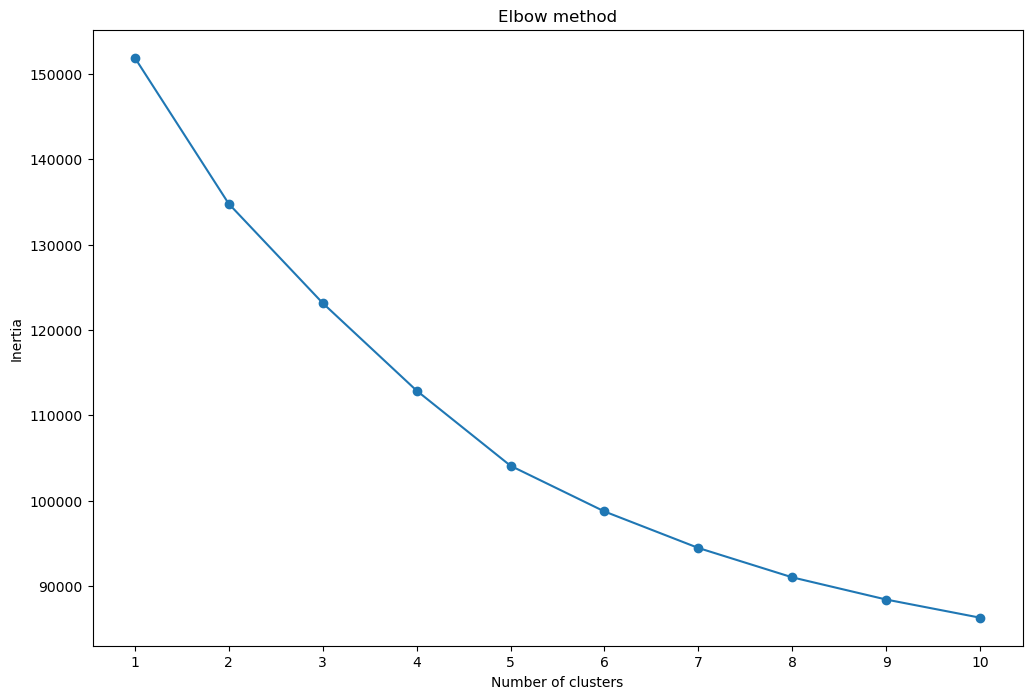

In [22]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit_predict(scaled_features)
    inertias.append(kmeans.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()    

Based on the graph above that the number of cluster is going to between 5 and 7. For simplicity sake we will use 6 as our value


In [23]:
model = KMeans(n_clusters=6)
y=model.fit_predict(scaled_features)
y

array([1, 3, 1, ..., 2, 5, 2], dtype=int32)

## Analyzing Results

All that's left now is to analyze the results. We need to see how the variables used in the clusterization differ from cluster to cluster in order better explain what each cluster represents.

We should note the most important characteristics of each cluster and how they can impact the business and marketing strategies for each type of customer.

Now, let's create a CLUSTER column in our original dataset so we can better understand the characteristics of each one.

In [24]:
df['cluster']=y+1

df.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,cluster
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,2
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,4
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,2
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,6
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,3


In [25]:
df['cluster'].value_counts()

3    2815
4    2448
2    1783
1    1443
5     909
6     729
Name: cluster, dtype: int64

We can see that cluster 3 is the largest while cluster 6 is the smallest.

Considering the numeric variable only, we'll check on the average value of each variable per cluster. We just need to group the data and plot a bar chart for each column.

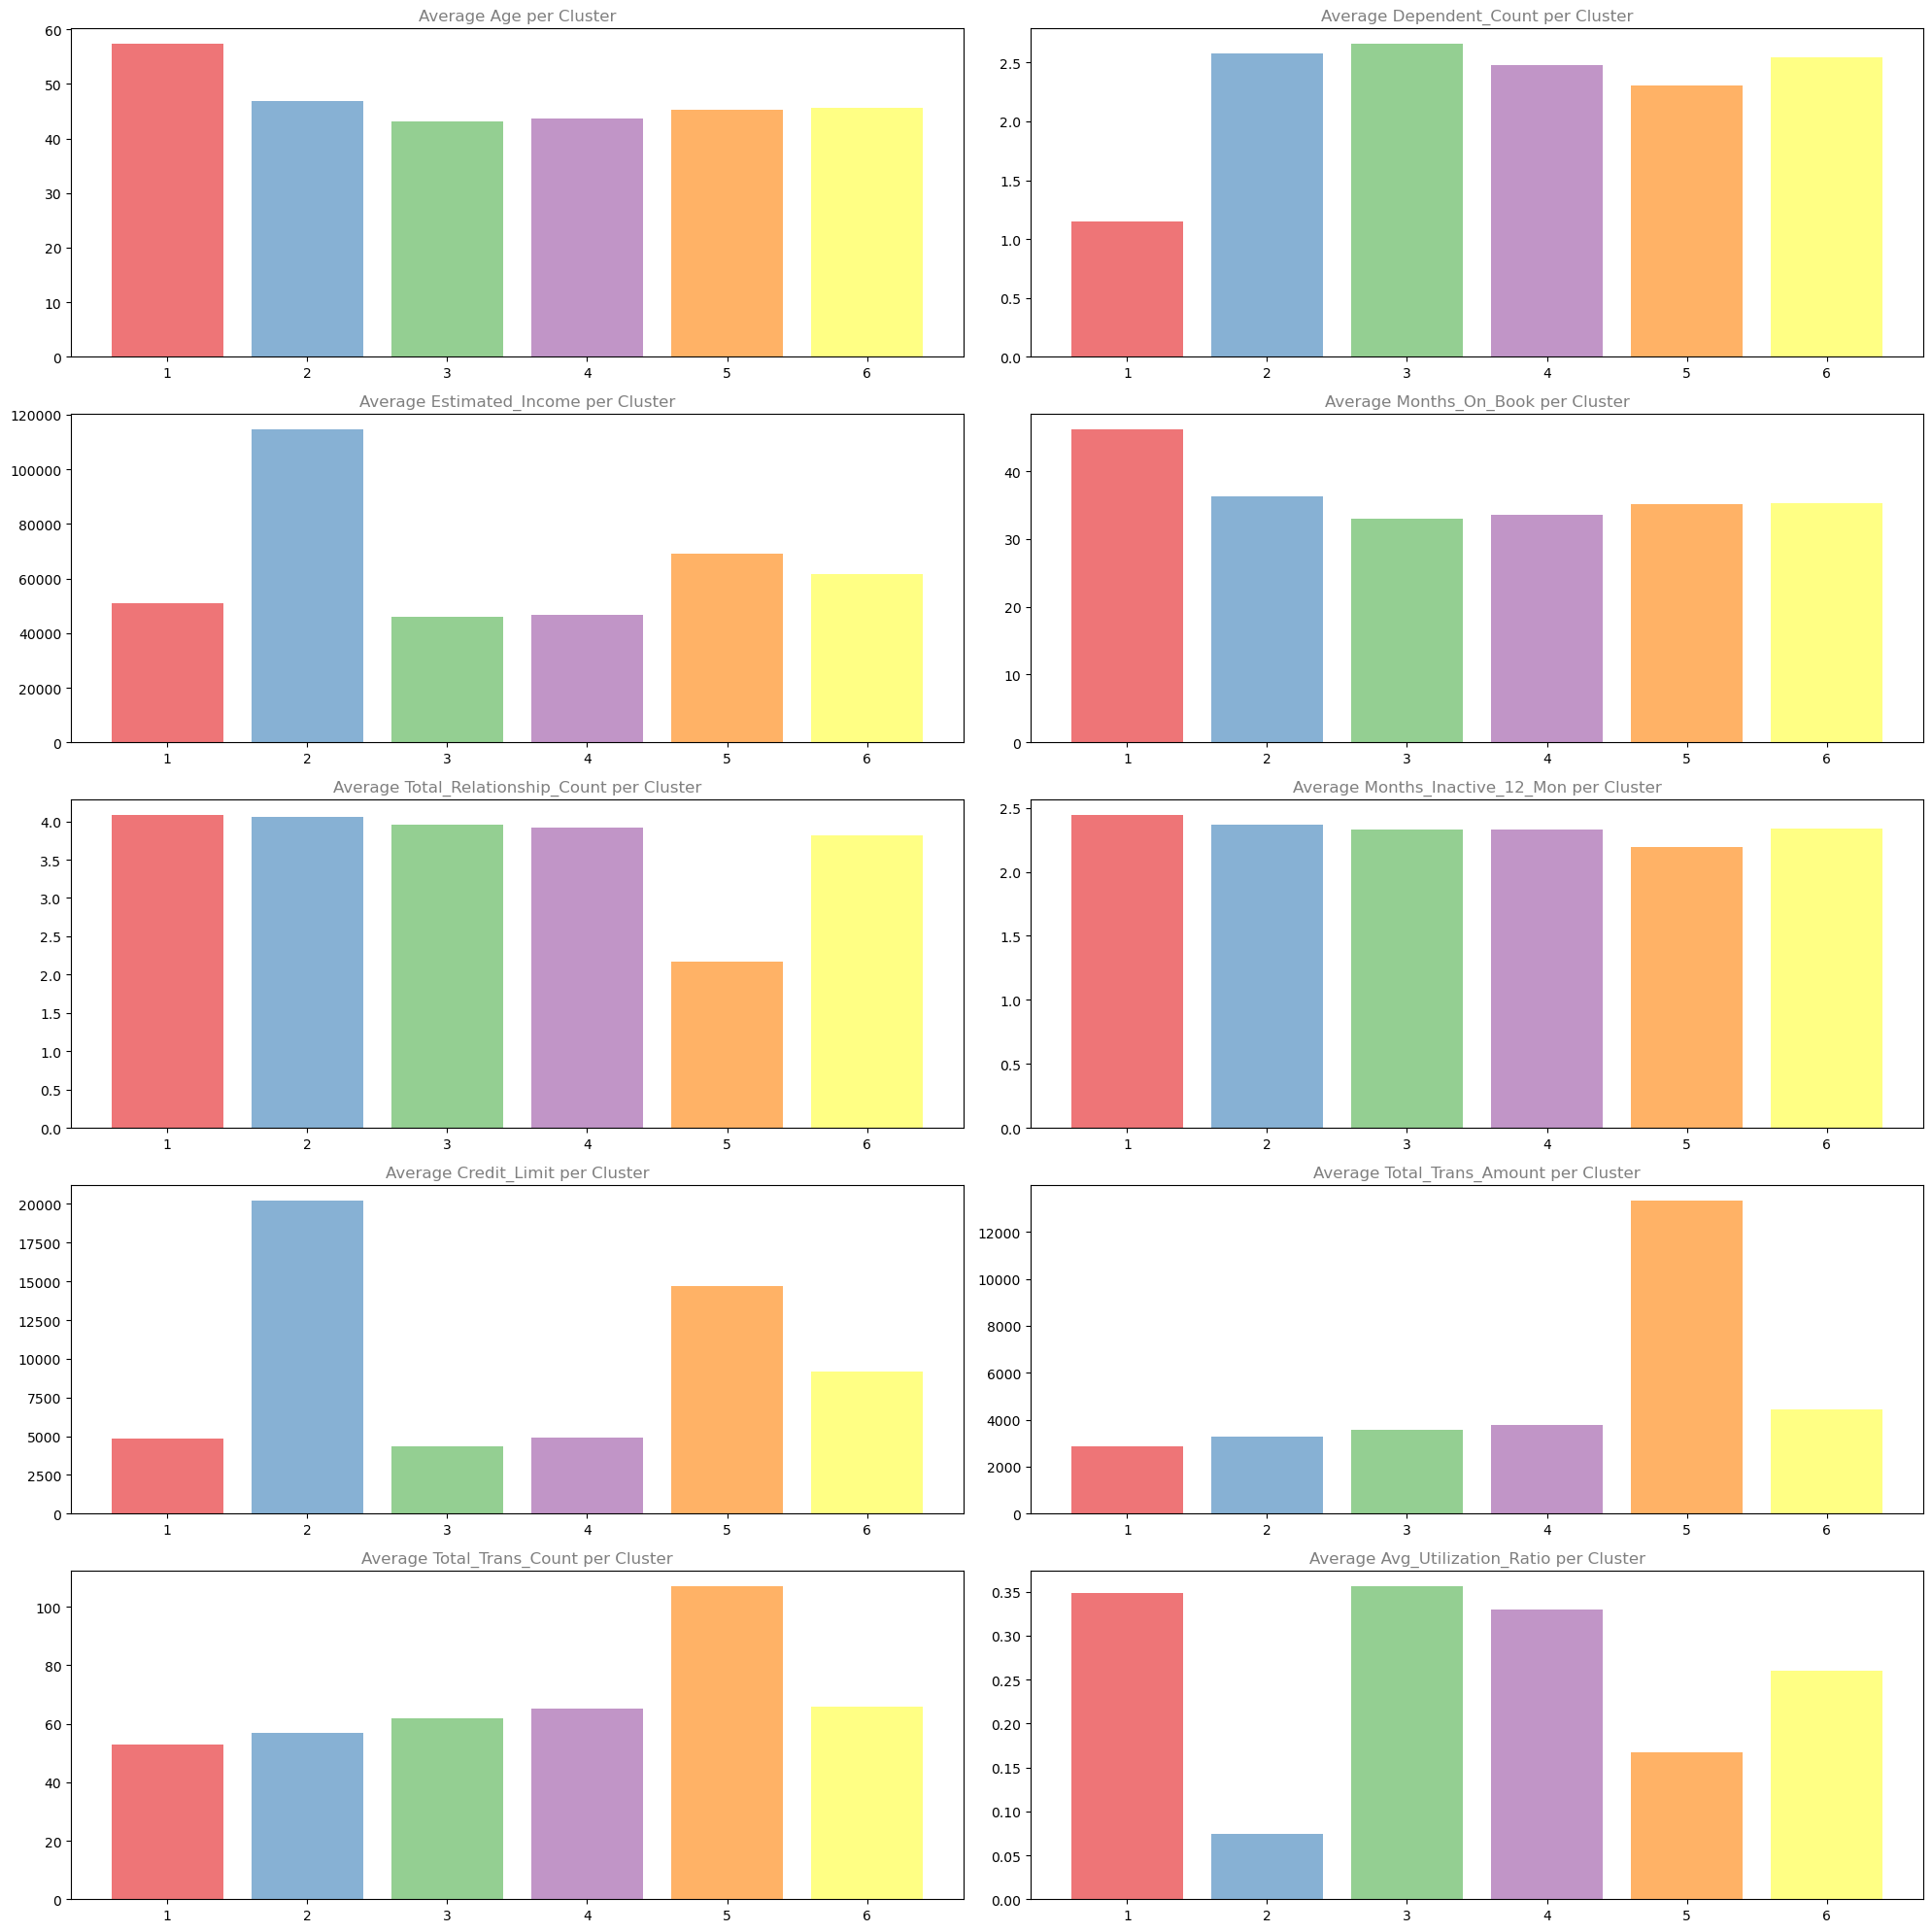

In [29]:
numeric_columns = df.select_dtypes(include=np.number).drop(['customer_id', 'cluster'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = df.groupby('cluster')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

For those numerical variables with higher correlations we saw earlier, we can also use a scatter plot to visualize this correlation grouped by clusters and analyze how the clusters change between each area of the chart.

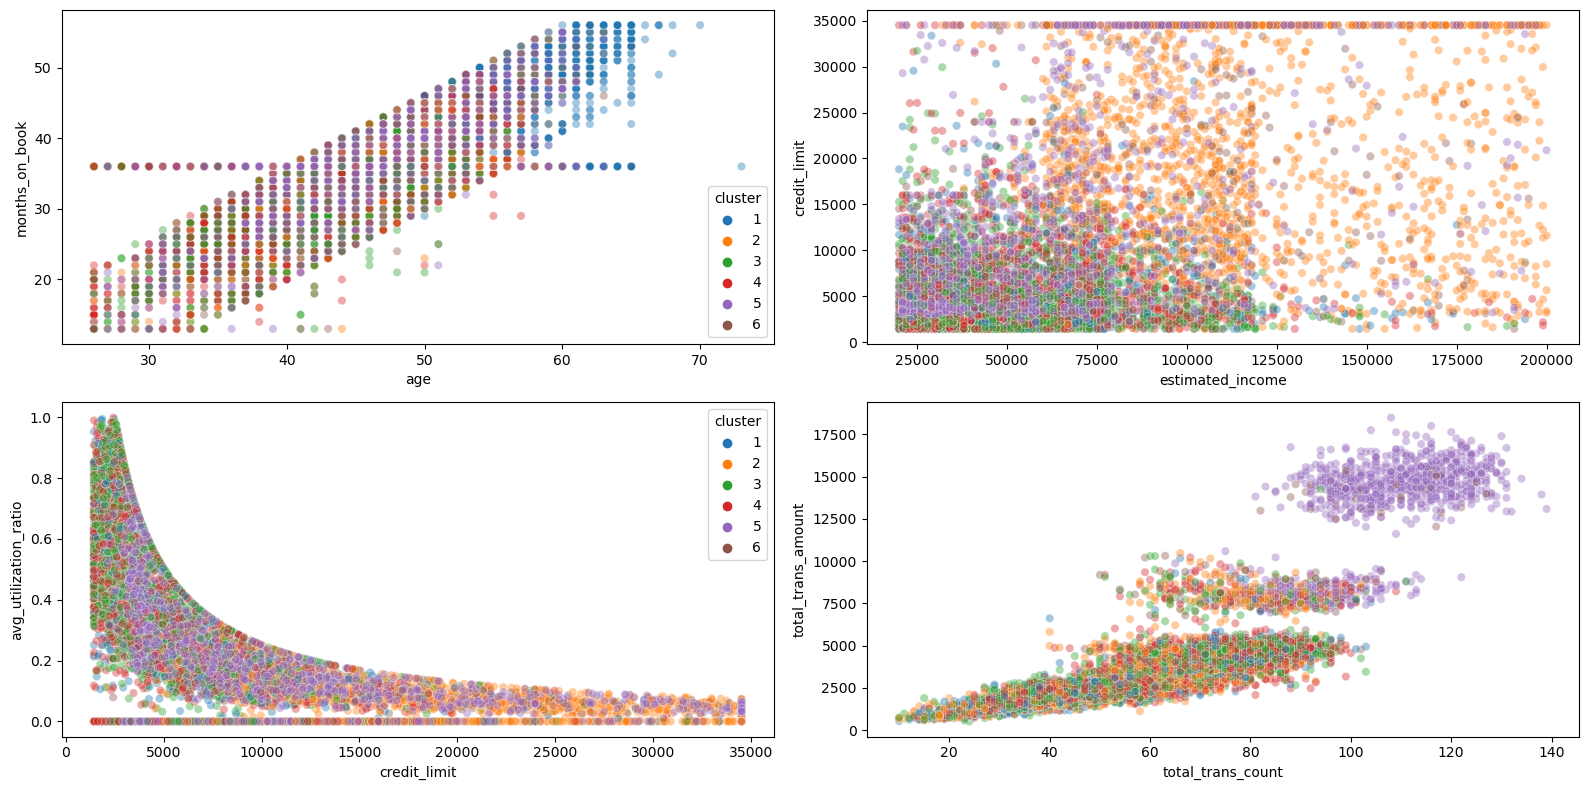

In [30]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='cluster', data=df, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='cluster', data=df, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='cluster', data=df, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='cluster', data=df, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()
     

We can draw some early conclusions considering only the numeric variables.

For instance, Cluster 5 has the highest amount of money transitioned, while Cluster 2 has the lowest credit limit and estimated income and the highest utilization rate. Cluster 3 has the highest credit limit. Older clients are grouped in Cluster 1.

For the categorical columns, we'll plot the percentual distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, or of married people only, for example.

/tmp/ipykernel_5693/1426870960.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
/tmp/ipykernel_5693/1426870960.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
/tmp/ipykernel_5693/1426870960.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


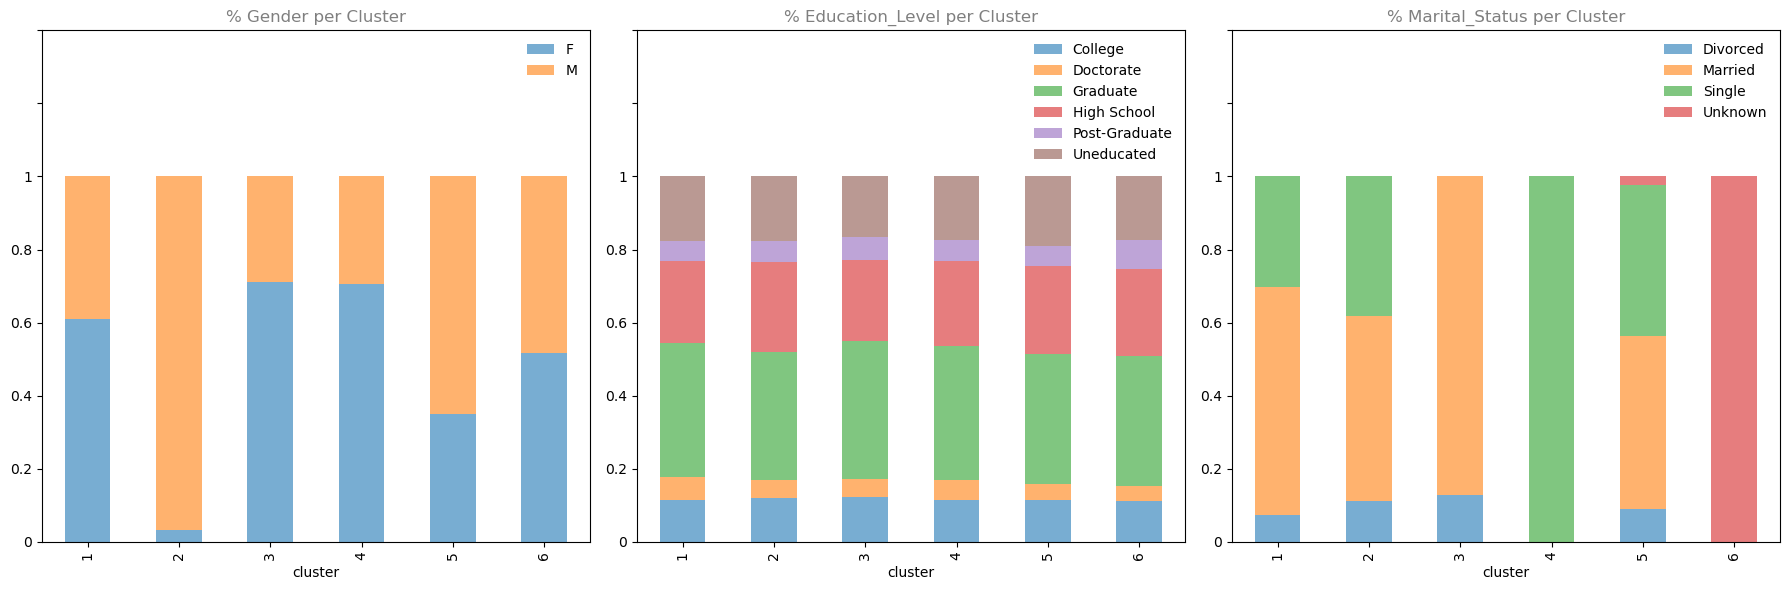

In [35]:

cat_columns = df.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=df['cluster'], columns=df[col], values=df[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()


Considering the categorical variables, we notice that the education level is well divided between clusters.

In other highlights, Cluster 2 is composed almost entirely of married people, while we don't know the marital status of anybody in Cluster 3. Cluster 4 is almost completely male and CLuster 6 is 100% made of single people.

## Conclusion
As demanded by the company, we now have listed the most important characteristics of each cluster. We could also some suggestions and insights into each one of them.

In the end, we have the list of customers with a cluster assigned to each one.

Cluster 1
Characteristics: Mostly men; high credit limit; high amount transitioned; high number of transactions; low utilization rate.

Insight: People with high volume spent on the card, but do not use it on a daily basis. Could be incentivized to use it more often.

Cluster 2
Characteristics: Mostly women; mostly married; low estimated income; low credit limit; low amount transitioned; high utilization rate.

Insight: Married people (majority women) with low income and limit but use the card too often. Could be given a bit more credit limit.

Cluster 3
Cluster 3: Gender well divided; low credit limit, high utilization rate; marital status 100% unknown; smaller cluster.

Insight: Men and women with low credit limits but use the card too often. Could be combined with Cluster 2.

Cluster 4
Cluster 4: Mostly men, mostly single and married, high estimated income, high credit limit; low amount transitioned; low utilization rate.

Insight: People (majority men) with high income and credit limits, but don't use the card. Could be incentivized to use it. Could have Cluster 1 (smaller) combined with it.

Cluster 5
Cluster 5: Mostly married, high age, low dependent count, long time customers, low credit limit, low amount transitioned, high utilization rate.

Insight: Older people and long-time customers. Low credit limit and transactions, but use the card very often. Could receive benefits to spend more money.

Cluster 6
Cluster 6: Mostly women; 100% single people, low estimated income, low credit limit, low amount transitioned, high utilization rate.

Insight: Single (mostly women) people that use their card a lot but have low credit limits and income. Could be given a bit more credit limit.